<div style="border-radius:10px; padding: 15px; background-color: #ffeacc; font-size:130%; text-align:left">

<h2 align="left"><font color=#ff6200>IPL ANALYSIS :</font></h2>

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

# MATCH DATASET OVERVIEW

In [2]:
matches_df=pd.read_csv('matches.csv')
score_df=pd.read_csv('deliveries.csv')

In [3]:
matches_df.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [4]:
matches_df.shape

(756, 18)

In [5]:
print(matches_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               756 non-null    int64 
 1   Season           756 non-null    object
 2   city             749 non-null    object
 3   date             756 non-null    object
 4   team1            756 non-null    object
 5   team2            756 non-null    object
 6   toss_winner      756 non-null    object
 7   toss_decision    756 non-null    object
 8   result           756 non-null    object
 9   dl_applied       756 non-null    int64 
 10  winner           752 non-null    object
 11  win_by_runs      756 non-null    int64 
 12  win_by_wickets   756 non-null    int64 
 13  player_of_match  752 non-null    object
 14  venue            756 non-null    object
 15  umpire1          754 non-null    object
 16  umpire2          754 non-null    object
 17  umpire3          119 non-null    ob

# DATA CLEANING & TRANSFORMATION

### Handling missing values

In [6]:
missing_data =matches_df .isnull().sum()

In [7]:
missing_data

id                   0
Season               0
city                 7
date                 0
team1                0
team2                0
toss_winner          0
toss_decision        0
result               0
dl_applied           0
winner               4
win_by_runs          0
win_by_wickets       0
player_of_match      4
venue                0
umpire1              2
umpire2              2
umpire3            637
dtype: int64

<Axes: >

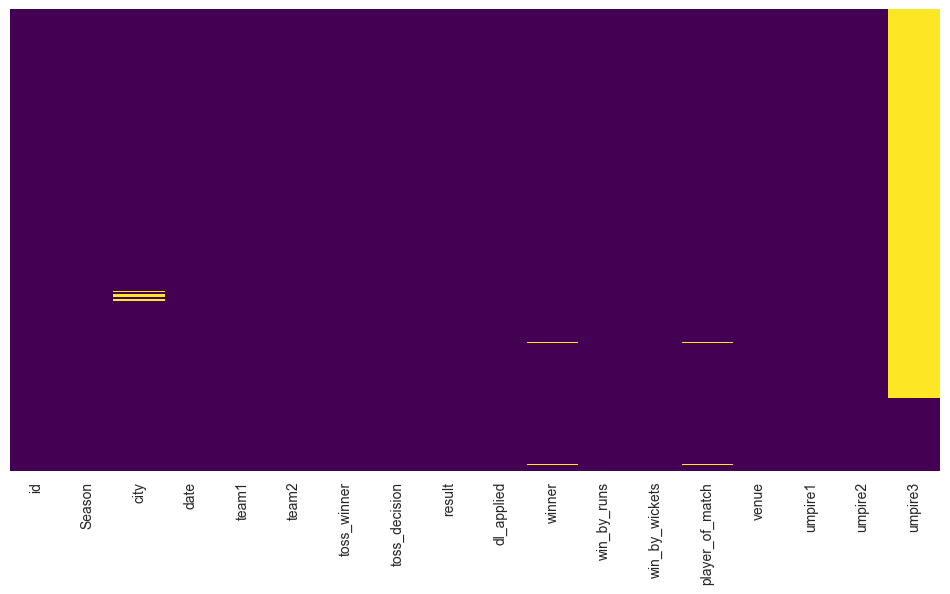

In [8]:
plt.rc('figure',figsize=(12,6))
plt.rcParams['figure.figsize']
sns.heatmap(matches_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [9]:
matches_df = matches_df.iloc[:,:-1]
matches_df.dropna(inplace=True)

In [10]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = matches_df[matches_df.duplicated(keep=False)]
duplicate_rows.sum()

id                 0
Season             0
city               0
date               0
team1              0
team2              0
toss_winner        0
toss_decision      0
result             0
dl_applied         0
winner             0
win_by_runs        0
win_by_wickets     0
player_of_match    0
venue              0
umpire1            0
umpire2            0
dtype: object

In [11]:
matches_df.describe()

,id,dl_applied,win_by_runs,win_by_wickets
count,743.000000,743.000000,743.000000,743.000000
mean,1786.578735,0.025572,13.460296,3.375505
std,3455.045846,0.157961,23.626205,3.393397
min,1.000000,0.000000,0.000000,0.000000
25%,187.500000,0.000000,0.000000,0.000000
50%,374.000000,0.000000,0.000000,4.000000
75%,567.500000,0.000000,19.000000,6.000000
max,11415.000000,1.000000,146.000000,10.000000


In [12]:
matches_df['id'].max()

11415

In [13]:
matches_df['Season'].unique()

array(['IPL-2017', 'IPL-2008', 'IPL-2009', 'IPL-2010', 'IPL-2011',
       'IPL-2012', 'IPL-2013', 'IPL-2014', 'IPL-2015', 'IPL-2016',
       'IPL-2018', 'IPL-2019'], dtype=object)

 ### Team won by Maximum Runs

In [14]:
matches_df.iloc[matches_df['win_by_runs'].idxmax()]

id                                          45
Season                                IPL-2017
city                                 Bangalore
date                                07-05-2017
team1              Royal Challengers Bangalore
team2                    Kolkata Knight Riders
toss_winner              Kolkata Knight Riders
toss_decision                            field
result                                  normal
dl_applied                                   0
winner                   Kolkata Knight Riders
win_by_runs                                  0
win_by_wickets                               6
player_of_match                      SP Narine
venue                    M Chinnaswamy Stadium
umpire1                            AY Dandekar
umpire2                          C Shamshuddin
Name: 44, dtype: object

In [15]:
matches_df.iloc[matches_df['win_by_runs'].idxmax()]['winner']

'Kolkata Knight Riders'

### Team won by Maximum Wickets

In [16]:
matches_df.iloc[matches_df['win_by_wickets'].idxmax()]['winner']

'Kolkata Knight Riders'

### Team won by minimum runs

In [17]:
matches_df.iloc[matches_df[matches_df['win_by_runs'].ge(1)].win_by_runs.idxmin()]['winner']

'Kolkata Knight Riders'

### Team won by Minimum Wickets

In [18]:
matches_df.iloc[matches_df[matches_df['win_by_wickets'].ge(1)].win_by_wickets.idxmin()]

id                                   570
Season                          IPL-2015
city                              Mumbai
date                          16-05-2015
team1                   Rajasthan Royals
team2              Kolkata Knight Riders
toss_winner             Rajasthan Royals
toss_decision                        bat
result                            normal
dl_applied                             0
winner                  Rajasthan Royals
win_by_runs                            9
win_by_wickets                         0
player_of_match                SR Watson
venue                  Brabourne Stadium
umpire1                     RM Deshpande
umpire2                   RK Illingworth
Name: 569, dtype: object

In [19]:
matches_df.iloc[matches_df[matches_df['win_by_wickets'].ge(1)].win_by_wickets.idxmin()]['winner']

'Rajasthan Royals'

Observation :

1.Mumbai Indians is the team which won by maximum and minimum runs

2.Kolkata Knight Riders is the team which won by maximum and minimum wickets

### Season Which had most number of matches

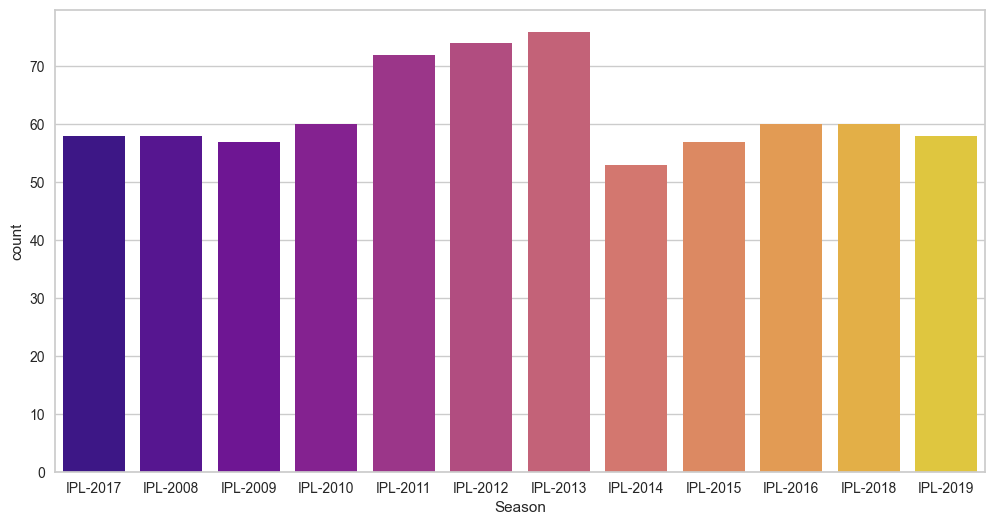

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(x='Season', data=matches_df  ,palette='plasma')
plt.show()


In 2013, we have the most number of matches

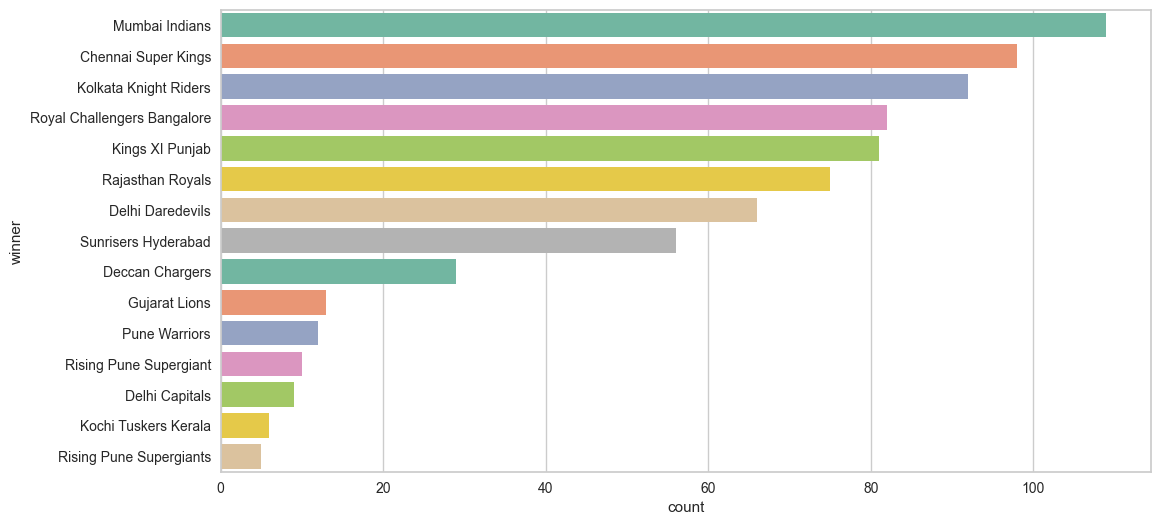

In [21]:
plt.figure(figsize=(12,6))
data = matches_df.winner.value_counts()
sns.barplot(y = data.index, x = data, orient='h',palette='Set2')
plt.show()

Mumbai Indians are the winners in most of the matches

### Top Player of the match winners

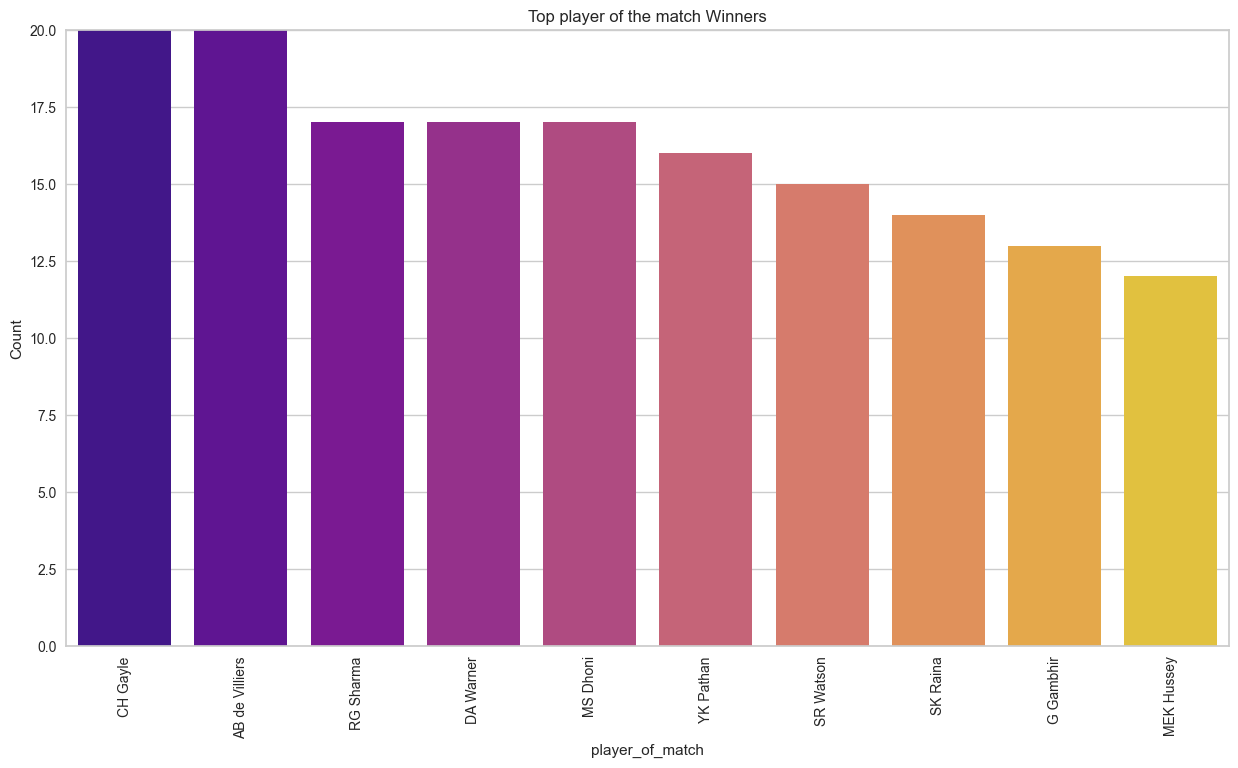

In [22]:
top_players = matches_df.player_of_match.value_counts()[:10]
fig, ax = plt.subplots(figsize=(15,8))
ax.set_ylim([0,20])
ax.set_ylabel("Count")
ax.set_title("Top player of the match Winners")
top_players.plot.bar()
sns.barplot(x = top_players.index, y = top_players, orient='v',palette='plasma' );
plt.show()

CH Gayle & AD de Villiers is the most Successful player in all match winners

### Number of matches in each venue:

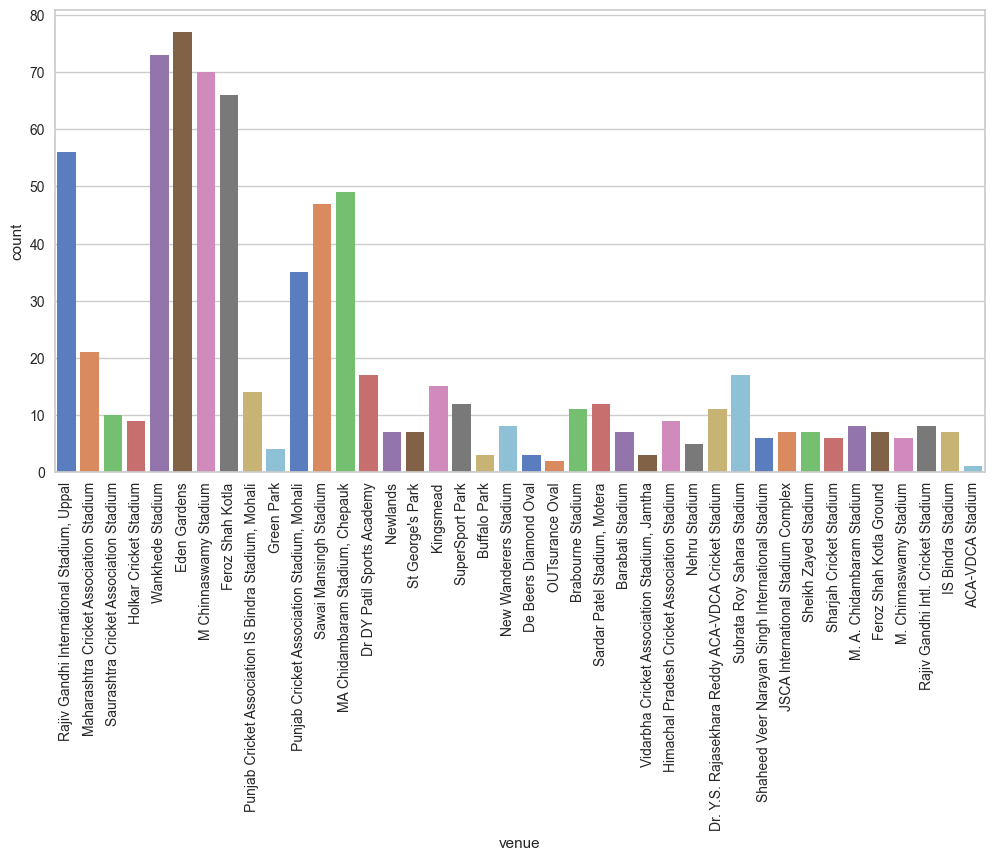

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(x='venue', data=matches_df,palette='muted')
plt.xticks(rotation='vertical')
plt.show()

There are quite a few venues present in the data with "Eden Gardens" being the one 
with most number of matches followed by "Wankhede Stadium" & "M Chinnaswamy Stadium"

### Number of matches played by each team:

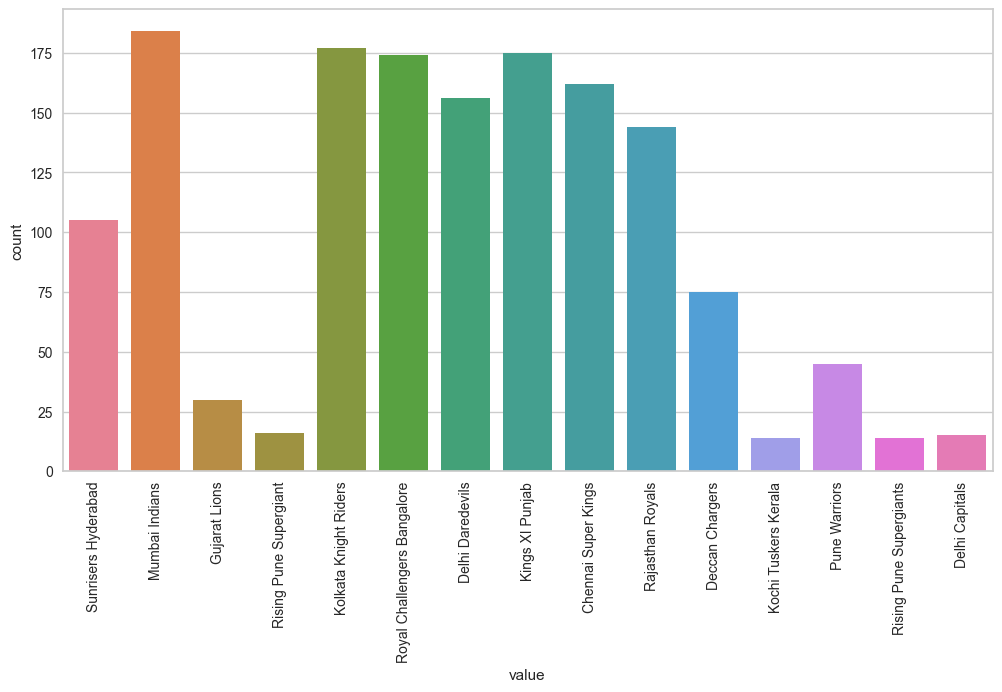

In [24]:
temp_df = pd.melt(matches_df, id_vars=['id','Season'], value_vars=['team1', 'team2'])

plt.figure(figsize=(12,6))
sns.countplot(x='value', data=temp_df, palette="husl")
plt.xticks(rotation='vertical')
plt.show()

"Mumbai Indians" lead the pack with most number of matches played followed by
"Kolkata Knight Riders". There are also teams with very few matches like 
'Rising Pune Supergiants', 'Kochi Tuskers Kerela' as they are new teams that came in only last season.

### Number of wins per team:

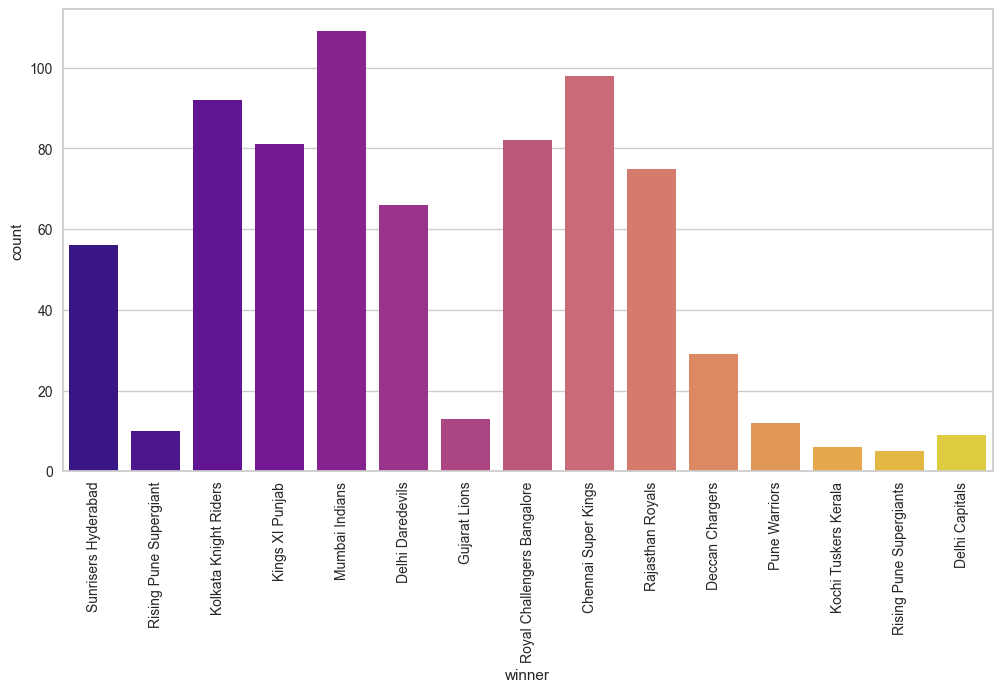

In [25]:
plt.figure(figsize=(12,6))
sns.countplot(x='winner', data=matches_df ,palette='plasma')
plt.xticks(rotation=90)
plt.show()

MI again leads the pack followed by CSK.

### Champions each season:

In [26]:
temp_df = matches_df.drop_duplicates(subset=['Season'], keep='last')[['Season', 'winner']].reset_index(drop=True)
temp_df

,Season,winner
0,IPL-2017,Mumbai Indians
1,IPL-2008,Rajasthan Royals
2,IPL-2009,Deccan Chargers
3,IPL-2010,Chennai Super Kings
4,IPL-2011,Chennai Super Kings
5,IPL-2012,Kolkata Knight Riders
6,IPL-2013,Mumbai Indians
7,IPL-2014,Kolkata Knight Riders
8,IPL-2015,Mumbai Indians
9,IPL-2016,Sunrisers Hyderabad


### Toss decision:

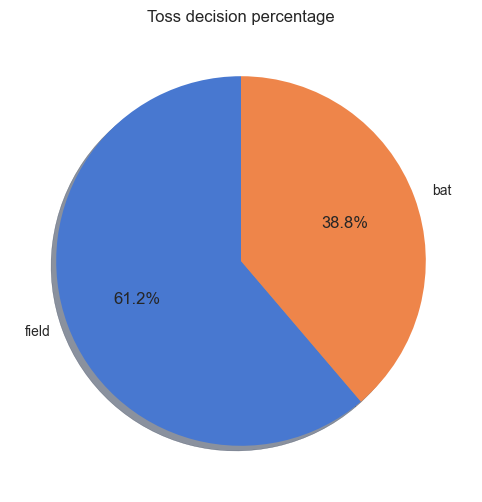

In [27]:

temp_series = matches_df.toss_decision.value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
colors = ['gold', 'lightskyblue']
plt.pie(sizes, labels=labels, colors=sns.color_palette('muted'),autopct='%1.1f%%', 
        shadow=True, startangle=90)
plt.title("Toss decision percentage")
plt.show()
          


So percentage of times teams Fielding first has won is 61.2%.
Now let us split this by year and see the distribution.

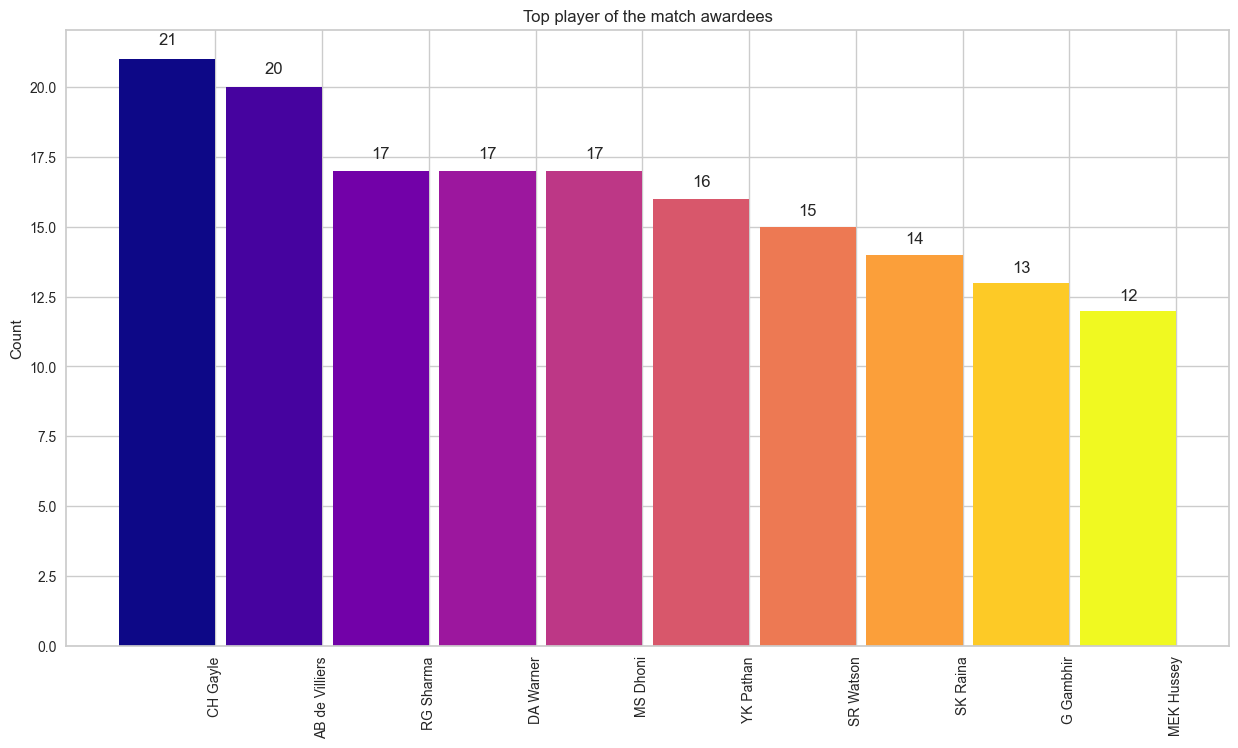

In [28]:
from matplotlib import cm
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.02*height,
                '%d' % int(height),
                ha='center', va='bottom')
        
temp_series = matches_df.player_of_match.value_counts()[:10]
labels = np.array(temp_series.index)
ind = np.arange(len(labels))

width = 0.9
fig, ax = plt.subplots(figsize=(15,8))
colors = cm.plasma(np.linspace(0, 1, len(labels)))
rects = ax.bar(ind, np.array(temp_series), width=width,color=colors )
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Top player of the match awardees")
autolabel(rects)
plt.show()

CH Gayle is the top player of the match awardee in all the seasons of IPL.

### Top Umpires:

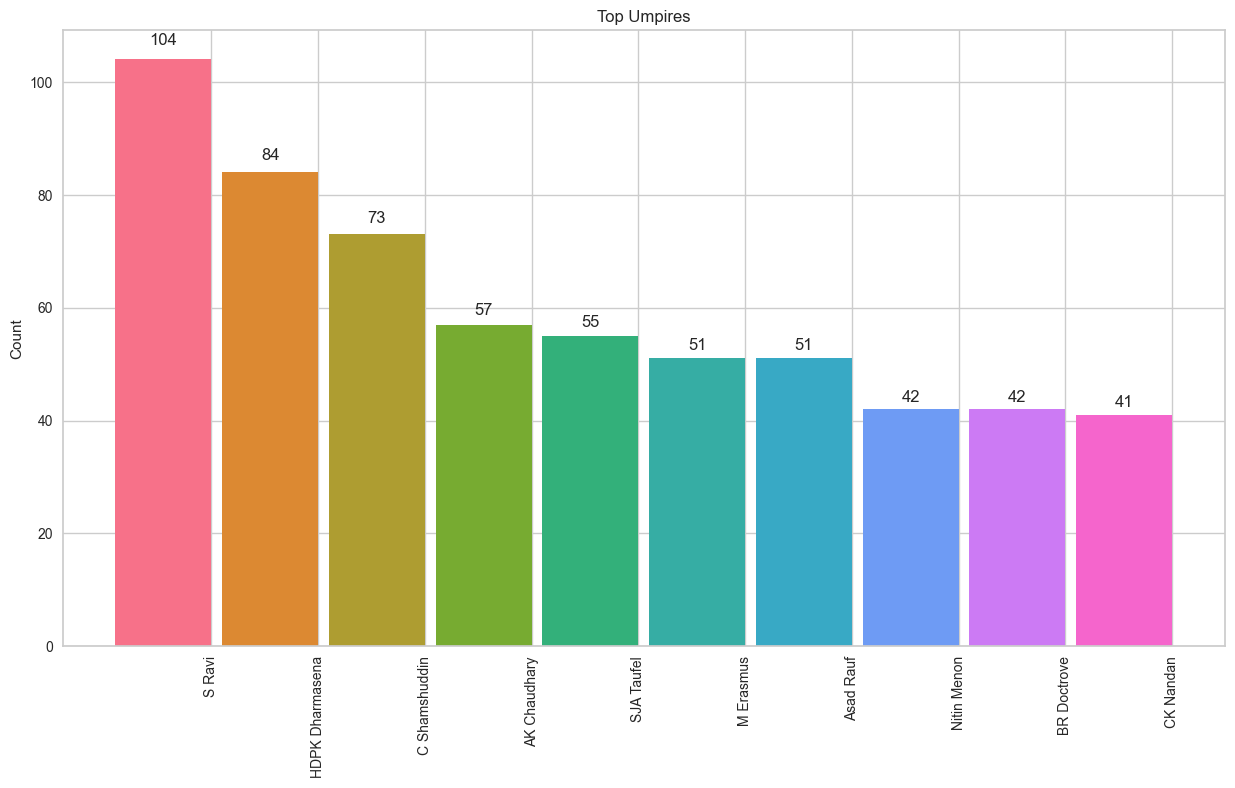

In [29]:
temp_df = pd.melt(matches_df, id_vars=['id'], value_vars=['umpire1', 'umpire2'])

temp_series = temp_df.value.value_counts()[:10]
labels = np.array(temp_series.index)
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))
colors = sns.color_palette("husl", len(labels))
rects = ax.bar(ind, np.array(temp_series), width=width,color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Top Umpires")
autolabel(rects)
plt.show()


S Ravi seems to be the most sought after umpire for IPL matches followed by HDPK Dharamasena. Others are fairly close to each other.

# SCORE DATA SET

In [30]:
score_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [31]:
score_df.shape

(179078, 21)

In [32]:
print(score_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179078 entries, 0 to 179077
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   match_id          179078 non-null  int64 
 1   inning            179078 non-null  int64 
 2   batting_team      179078 non-null  object
 3   bowling_team      179078 non-null  object
 4   over              179078 non-null  int64 
 5   ball              179078 non-null  int64 
 6   batsman           179078 non-null  object
 7   non_striker       179078 non-null  object
 8   bowler            179078 non-null  object
 9   is_super_over     179078 non-null  int64 
 10  wide_runs         179078 non-null  int64 
 11  bye_runs          179078 non-null  int64 
 12  legbye_runs       179078 non-null  int64 
 13  noball_runs       179078 non-null  int64 
 14  penalty_runs      179078 non-null  int64 
 15  batsman_runs      179078 non-null  int64 
 16  extra_runs        179078 non-null  int

# DATA CLEANING & TRANSFORMATION

In [33]:
Missing_data =score_df.isnull().sum()
Missing_data

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
is_super_over            0
wide_runs                0
bye_runs                 0
legbye_runs              0
noball_runs              0
penalty_runs             0
batsman_runs             0
extra_runs               0
total_runs               0
player_dismissed    170244
dismissal_kind      170244
fielder             172630
dtype: int64

In [34]:
score_df = score_df.iloc[:,:-3]
score_df.dropna(inplace=True)

In [35]:
score_df.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs'],
      dtype='object')

In [36]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = score_df[score_df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs'])

# Displaying the first 10 records
duplicate_rows_sorted.head(10)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs
52169,221,1,Mumbai Indians,Delhi Daredevils,4,1,SR Tendulkar,C Madan,PJ Sangwan,0,0,0,0,0,0,1,0,1
52178,221,1,Mumbai Indians,Delhi Daredevils,4,1,SR Tendulkar,C Madan,PJ Sangwan,0,0,0,0,0,0,1,0,1
162803,7946,1,Rajasthan Royals,Royal Challengers Bangalore,4,4,AM Rahane,RA Tripathi,UT Yadav,0,0,0,0,0,0,4,0,4
162805,7946,1,Rajasthan Royals,Royal Challengers Bangalore,4,4,AM Rahane,RA Tripathi,UT Yadav,0,0,0,0,0,0,4,0,4
162804,7946,1,Rajasthan Royals,Royal Challengers Bangalore,4,5,AM Rahane,RA Tripathi,UT Yadav,0,0,0,0,0,0,1,0,1
162806,7946,1,Rajasthan Royals,Royal Challengers Bangalore,4,5,AM Rahane,RA Tripathi,UT Yadav,0,0,0,0,0,0,1,0,1
162863,7946,1,Rajasthan Royals,Royal Challengers Bangalore,13,5,RA Tripathi,AM Rahane,YS Chahal,0,0,0,0,0,0,0,0,0
162870,7946,1,Rajasthan Royals,Royal Challengers Bangalore,13,5,RA Tripathi,AM Rahane,YS Chahal,0,0,0,0,0,0,0,0,0
162963,7946,2,Royal Challengers Bangalore,Rajasthan Royals,10,1,AB de Villiers,Mandeep Singh,I Sodhi,0,0,0,0,0,0,0,0,0
162964,7946,2,Royal Challengers Bangalore,Rajasthan Royals,10,1,AB de Villiers,Mandeep Singh,I Sodhi,0,0,0,0,0,0,0,0,0


In [37]:
# Displaying the number of duplicate rows
print(f"The dataset contains {score_df.duplicated().sum()} duplicate rows that need to be removed.")


The dataset contains 24 duplicate rows that need to be removed.


In [38]:
# Removing duplicate rows
score_df.drop_duplicates(inplace=True)

### Batsman analysis:

Let us start our analysis with batsman. Let us first see the ones with most number of IPL runs under their belt.

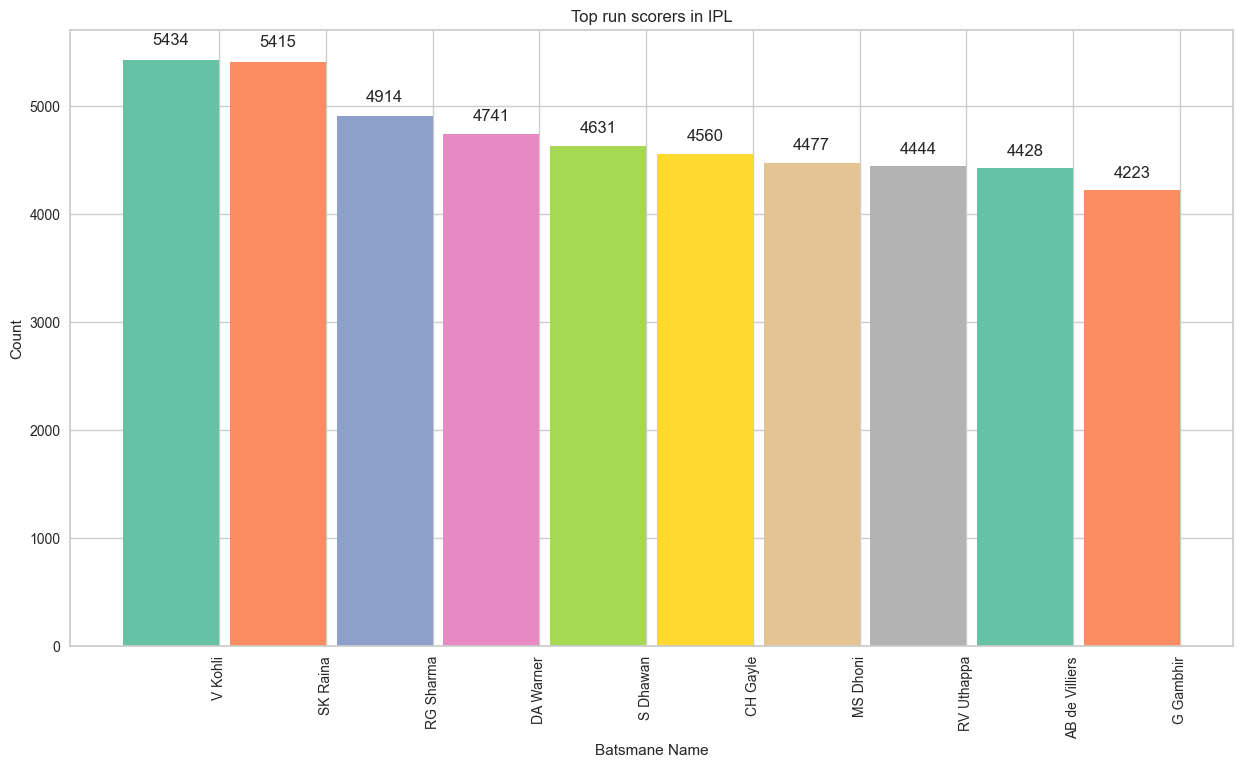

In [39]:
temp_df = score_df.groupby('batsman')['batsman_runs'].agg('sum').reset_index().sort_values(by='batsman_runs', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

labels = np.array(temp_df['batsman'])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))

colors = sns.color_palette("Set2", len(labels))
rects = ax.bar(ind, np.array(temp_df['batsman_runs']), width=width, color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Top run scorers in IPL")
ax.set_xlabel('Batsmane Name')
autolabel(rects)
plt.show()

Virat Kohli is leading the chart followed closely by Raina. Gayle is the top scorer among foreign players.

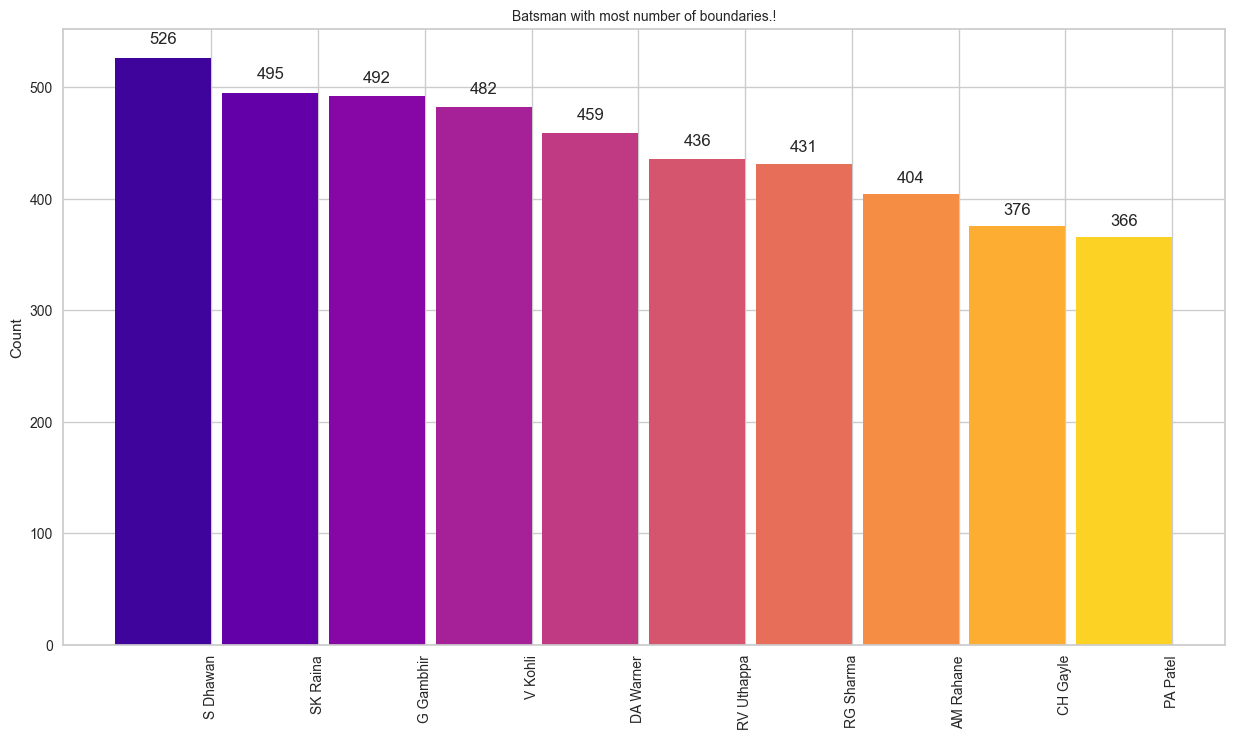

In [40]:
# Now let us see the players with more number of boundaries in IPL.
temp_df = score_df.groupby('batsman')['batsman_runs'].agg(lambda x: (x==4).sum()).reset_index().sort_values(by='batsman_runs', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

labels = np.array(temp_df['batsman'])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))

colors = sns.color_palette("plasma", len(labels))
rects = ax.bar(ind, np.array(temp_df['batsman_runs']), width=width, color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Batsman with most number of boundaries.!",fontsize = 10)
autolabel(rects)
plt.show()

Shikhar dhawan has most boundaries

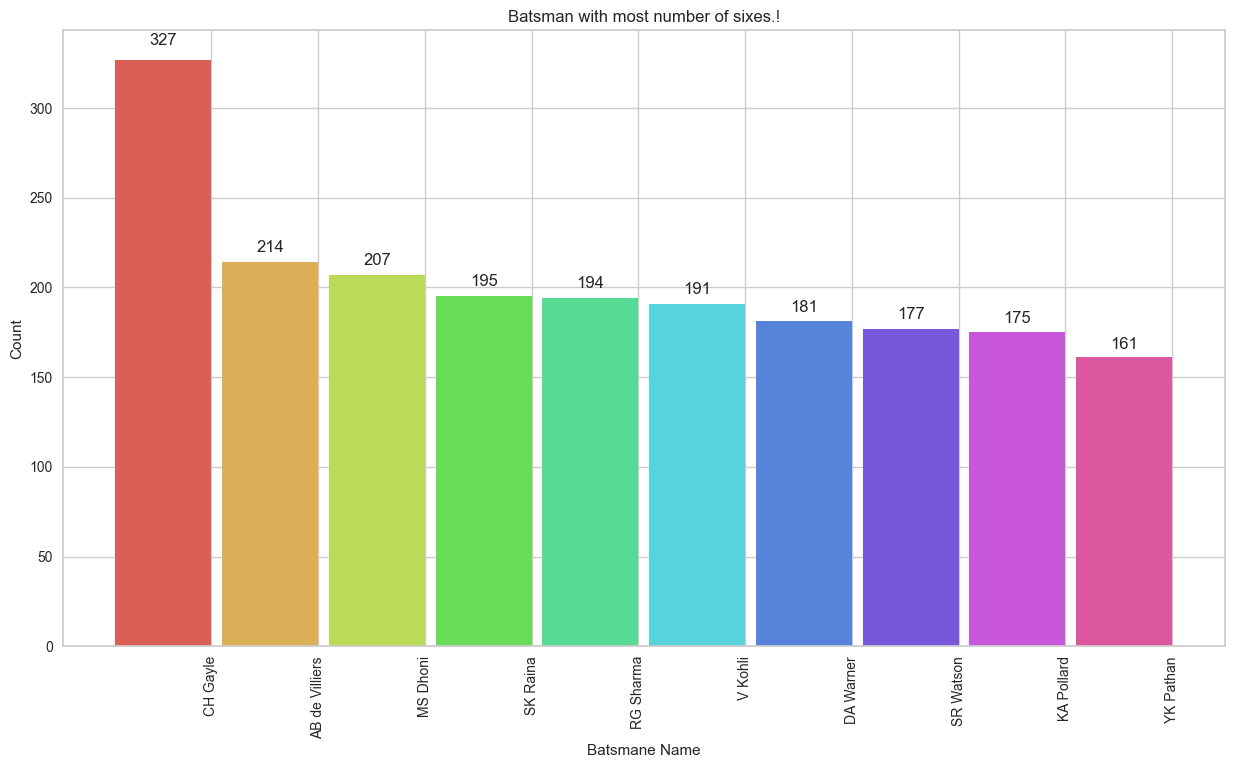

In [41]:
# Now let us check the number of 6's
temp_df = score_df.groupby('batsman')['batsman_runs'].agg(lambda x: (x==6).sum()).reset_index().sort_values(by='batsman_runs', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

labels = np.array(temp_df['batsman'])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))

colors = sns.color_palette("hls", len(labels))
rects = ax.bar(ind, np.array(temp_df['batsman_runs']), width=width, color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel("Count")
ax.set_title("Batsman with most number of sixes.!")
ax.set_xlabel('Batsmane Name')
autolabel(rects)
plt.show()

Most nuber of sixes are hitted by CH Gayle

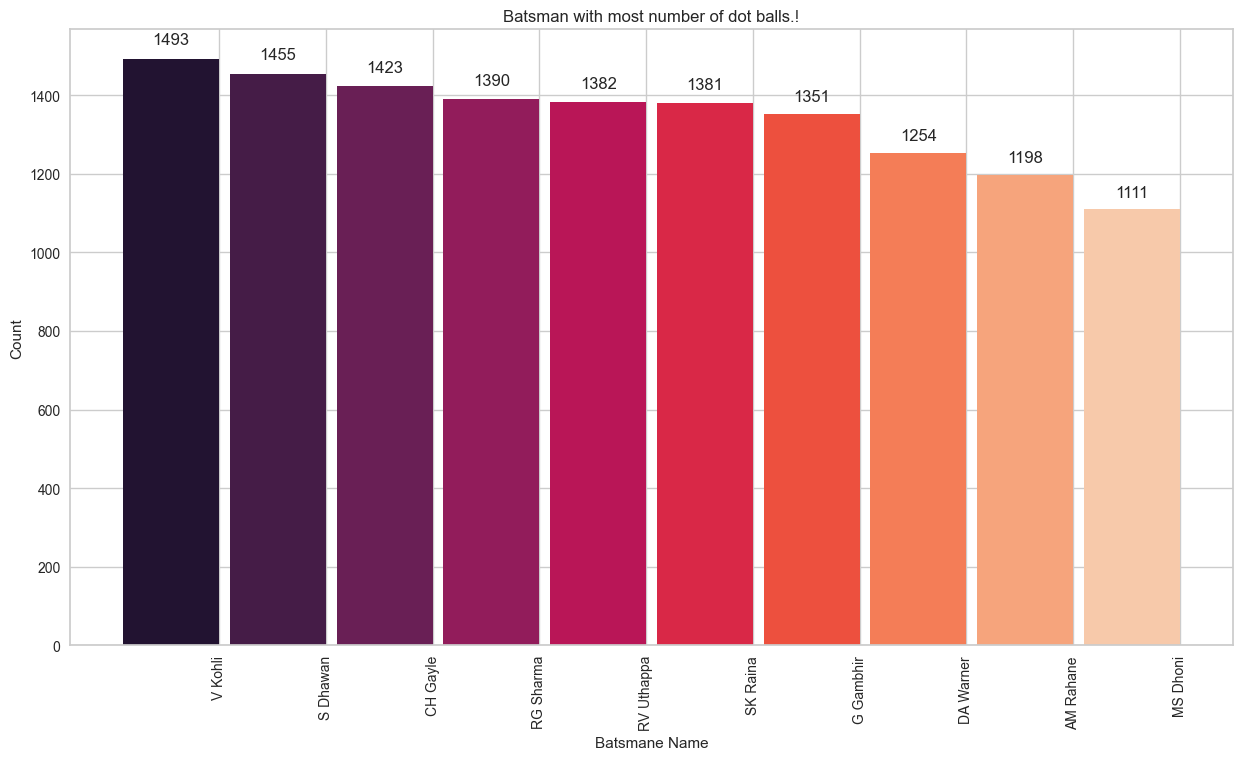

In [42]:
# Now let us see the batsman who has played the most number of dot balls.
temp_df = score_df.groupby('batsman')['batsman_runs'].agg(lambda x: (x==0).sum()).reset_index().sort_values(by='batsman_runs', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

labels = np.array(temp_df['batsman'])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))

colors = sns.color_palette("rocket", len(labels))
rects = ax.bar(ind, np.array(temp_df['batsman_runs']), width=width, color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Batsman with most number of dot balls.!")
ax.set_xlabel('Batsmane Name')
autolabel(rects)
plt.show()

Virat Kohli has played the most number of dot balls

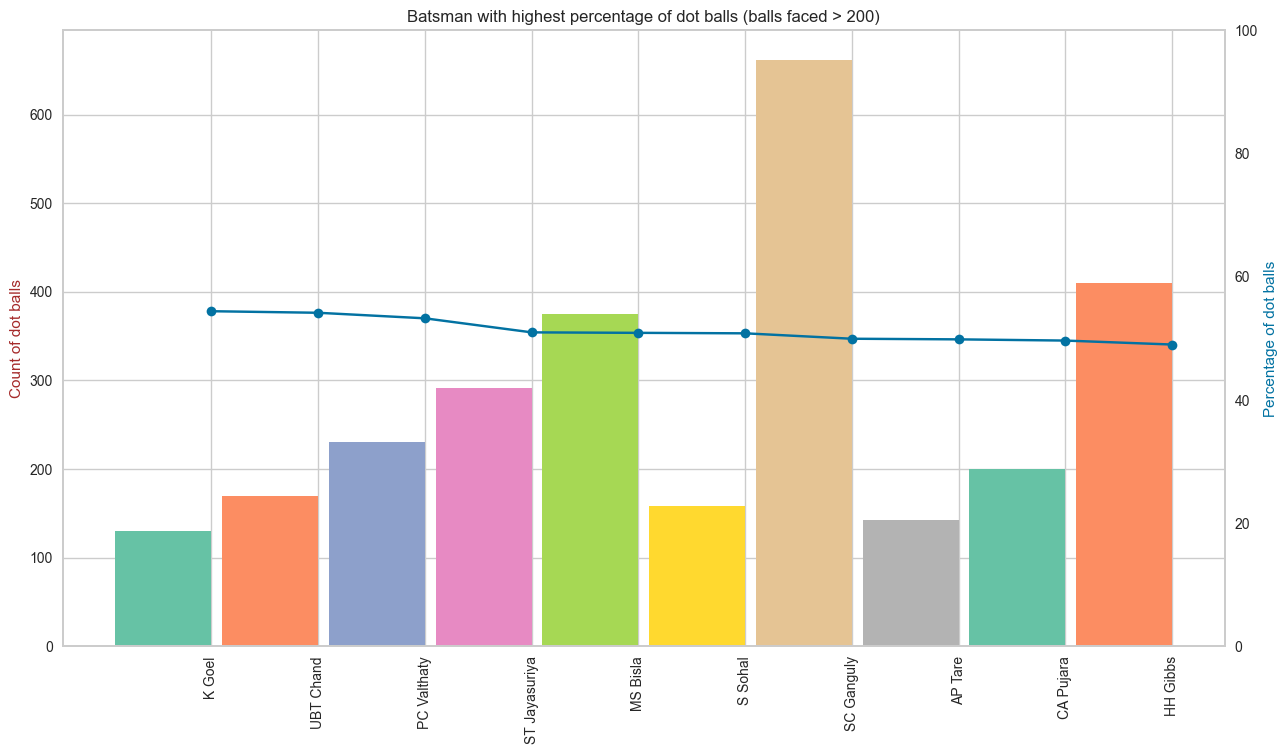

In [43]:
# Let us check the percentage distribution now.
def balls_faced(x):
    return len(x)

def dot_balls(x):
    return (x==0).sum()

temp_df = score_df.groupby('batsman')['batsman_runs'].agg([balls_faced, dot_balls]).reset_index()
temp_df = temp_df.loc[temp_df.balls_faced>200,:]
temp_df['percentage_of_dot_balls'] = (temp_df['dot_balls'] / temp_df['balls_faced'])*100.
temp_df = temp_df.sort_values(by='percentage_of_dot_balls', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
labels = np.array(temp_df['batsman'])
ind = np.arange(len(labels))
width = 0.9

colors = sns.color_palette("Set2", len(labels))
rects = ax1.bar(ind, np.array(temp_df['dot_balls']), width=width, color=colors)
ax1.set_xticks(ind+((width)/2.))
ax1.set_xticklabels(labels, rotation='vertical')
ax1.set_ylabel("Count of dot balls", color='brown')
ax1.set_title("Batsman with highest percentage of dot balls (balls faced > 200)")
ax2.plot(ind+0.45, np.array(temp_df['percentage_of_dot_balls']), color='b', marker='o')
ax2.set_ylabel("Percentage of dot balls", color='b')
ax2.set_ylim([0,100])
ax2.grid(visible=False) 
plt.show()


Batsman with more than 300 balls faced in taken and the ones with higher percentage of dot balls are seen. It is interesting to see Ganguly with more than 1000 balls and nearly half of them are dot balls.

### Bowler Analysis

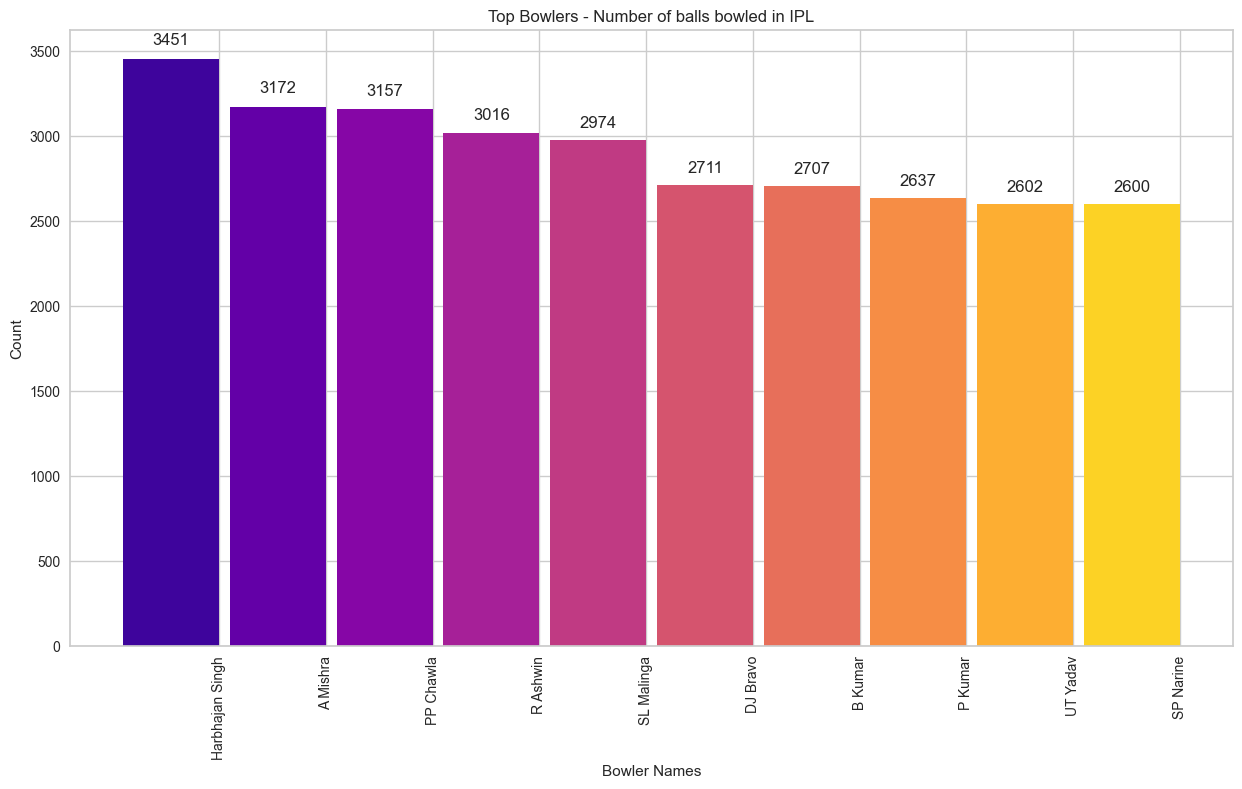

In [44]:
temp_df = score_df.groupby('bowler')['ball'].agg('count').reset_index().sort_values(by='ball', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

labels = np.array(temp_df['bowler'])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))

colors = sns.color_palette("plasma", len(labels))
rects = ax.bar(ind, np.array(temp_df['ball']), width=width, color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Top Bowlers - Number of balls bowled in IPL")
ax.set_xlabel('Bowler Names')
autolabel(rects)
plt.show()

Harbhajan Singh is the the bowler with most number of balls bowled in IPL matches.

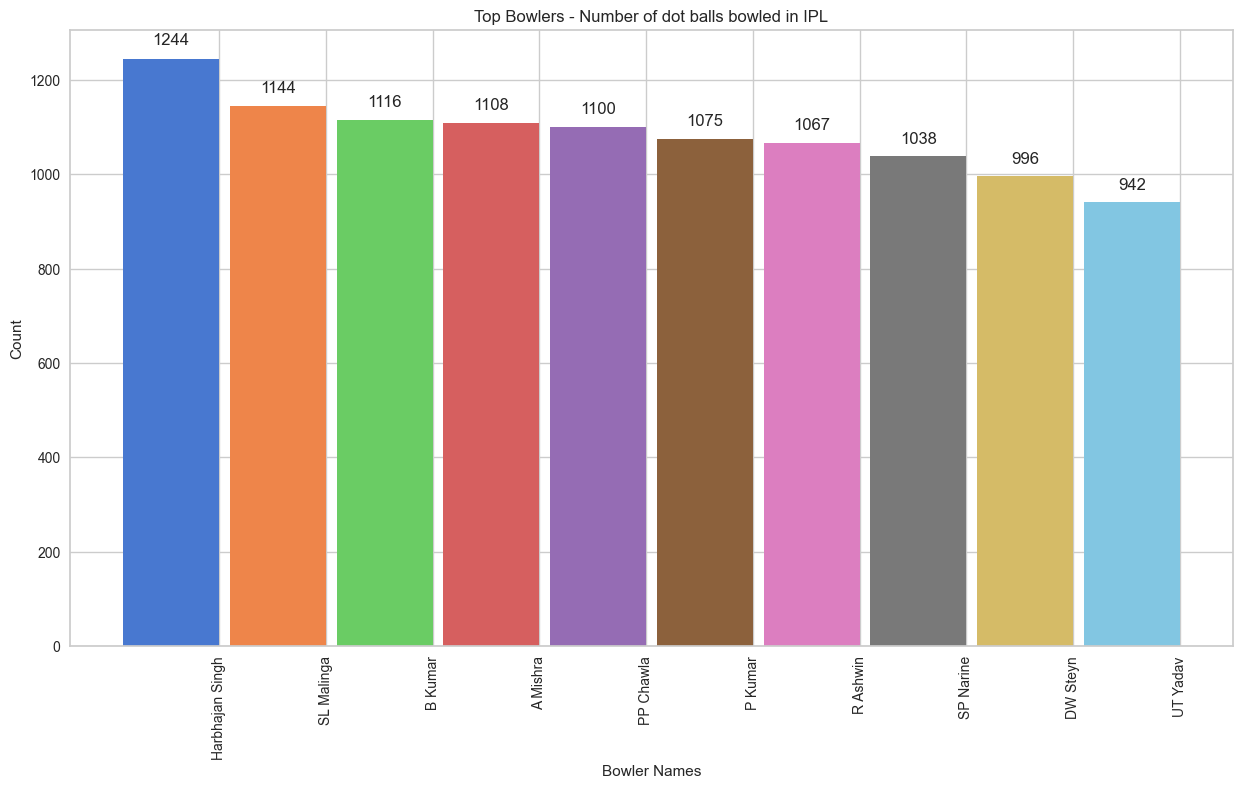

In [45]:
#Now let us see the bowler with more number of dot balls.
temp_df = score_df.groupby('bowler')['total_runs'].agg(lambda x: (x==0).sum()).reset_index().sort_values(by='total_runs', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

labels = np.array(temp_df['bowler'])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))

colors = sns.color_palette("muted", len(labels))
rects = ax.bar(ind, np.array(temp_df['total_runs']), width=width, color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Top Bowlers - Number of dot balls bowled in IPL")
ax.set_xlabel('Bowler Names')
autolabel(rects)
plt.show()

Harbhajan Singh is the one with more number of dot balls followed by Malinga and B Kumar

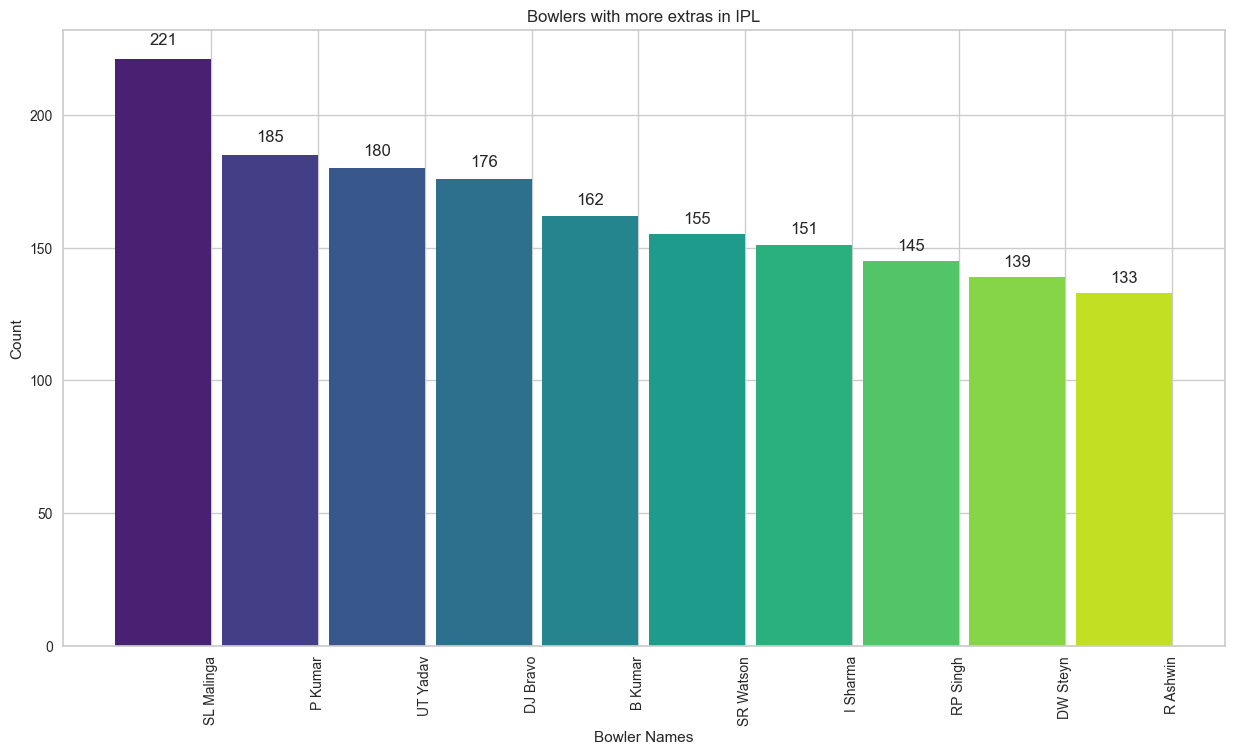

In [46]:
# Now let us see the bowlers who has bowled more number of extras in IPL.
temp_df = score_df.groupby('bowler')['extra_runs'].agg(lambda x: (x>0).sum()).reset_index().sort_values(by='extra_runs', ascending=False).reset_index(drop=True)
temp_df = temp_df.iloc[:10,:]

labels = np.array(temp_df['bowler'])
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(15,8))

colors = sns.color_palette("viridis", len(labels))
rects = ax.bar(ind, np.array(temp_df['extra_runs']), width=width, color=colors)
ax.set_xticks(ind+((width)/2.))
ax.set_xticklabels(labels, rotation='vertical')
ax.set_ylabel("Count")
ax.set_title("Bowlers with more extras in IPL")
ax.set_xlabel('Bowler Names')
autolabel(rects)
plt.show()

Malinga tops the chart with 221 extra runs followed by Pravin Kumar.